In [ ]:
## 이미지 캡셔닝 1차 모델 구축
  ## 베이스 아키텍처: Show, Attend and Tell
  ## 추가 확보 데이터: vocab(from pre-trained model)
  ## 프로세스
    ## 데이터 로드, 체크
    ## 텍스트 데이터 추가 전처리(정규화, 토큰화, 패딩)
    ## 이미지 데이터 전처리
    ## 모델 정의: CNN, Attention, LSTM
    ## 기타 사용자 정의 함수 생성(손실함수 등)
    ## 모델 컴파일 및 훈련
    ## 모델 검증(테스트 데이터 확인, 학습결과 시각화, 매트릭스 출력)

In [ ]:
"""
Notice: about ignoring Warning log and Error log message

when importing tensorflow packages and using them with absl, there might be several warning, error messages.
1) NUMA warning: NUMA is a tool for optimizing memory allocation.
    It is normally used in massive server group, therefore, if you use personal device, just ignore it

2) Type Inference failed: It can be caused by type differences between X_data and Y_data.
    In this model, X_data(image features, text sequences) type is float32 and Y_data(text label) type is int32.
    For this differences, the system might be confused becasue it is ordered to predict int values but it received float type values.
    This confilict can be solved by chaning value type of Y_data before train(tf.cast(y, tf.float32)).
    However, when you use "sparse-categorical-crossentropy" as loss function, Y_data must be type int32.
    Therefore, if model train goes well, this error cam be ingnored. Otherwise, it is caused by other problems such as model structure and you must fix this.

3) In conclusion, if model training goes well, you can ignore them. They are just matter of system optimization.

4) If you want them not to be printed. Use this configuration code.
[tensorflow]
    import os
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')
[absl]
    from absl import logging
    logging.set_verbosity(logging.ERROR)
"""

In [1]:
import tensorflow as tf
from absl import logging

tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

2024-01-26 17:57:22.774011: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 17:57:22.996797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 17:57:22.996829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 17:57:23.013426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 17:57:23.092954: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
## Data load(in case working in colab)
"""
from google.colab import drive
import os

drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/pjt_3_data/train_sample_2.zip'
%mkdir 'train_sample_2'

!cp "{zip_file_path}" "/content/"

!unzip -q "/content/train_sample_2.zip" -d "/content/train_sample_2/"

print('unizipped files: ', os.listdir('/content/train_sample_2'))
"""

In [2]:
## text data additional preprocessing for model train

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

In [3]:
df = pd.read_csv('./train_sample_2000.csv', encoding='utf-8')
df.head(2)

,id,height,width,file_name,category,sentence_en
0,446250,1920,1440,IMG_0446250_person(person).jpg,person,a man is holding an umbrella
1,446251,1920,1080,IMG_0446251_person(person).jpg,person,a man is turning on a gas stove


In [4]:
## text data preprocessing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

def preprocess_and_tokenize(df, text_column='sentence_en'):
  def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

  start_token = '<start>'
  end_token = '<end>'
  pad_token = '<pad>'
  unk_token = '<unk>'

  df['cleaned_sentence'] = df[text_column].apply(clean_text)

  tokenizer = Tokenizer(oov_token=unk_token)
  tokenizer.fit_on_texts(df['cleaned_sentence'])

  tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
  tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1
  tokenizer.word_index[pad_token] = 0
  tokenizer.word_index[unk_token] = len(tokenizer.word_index) + 1
  tokenizer.index_word[0] = pad_token
  tokenizer.index_word[len(tokenizer.word_index)] = unk_token
  start_token_id = tokenizer.word_index[start_token]
  end_token_id = tokenizer.word_index[end_token]

  sequences = tokenizer.texts_to_sequences(df['cleaned_sentence'])
  sequences = [[tokenizer.word_index[start_token]] + seq + [tokenizer.word_index[end_token]] for seq in sequences]

  max_length = max(len(sequence) for sequence in sequences)
  sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post', value=tokenizer.word_index[pad_token])

  vocab_size = len(tokenizer.word_index) + 1

  x_data_text = sequences_padded[:, :-1]
  y_data = sequences_padded[:, 1:]

  max_sequence_length = max_length - 1

  return x_data_text, y_data, vocab_size, tokenizer, max_sequence_length, start_token_id, end_token_id


In [5]:
## image data preprocessing for model train

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

image_folder = './image'

In [6]:
def process_image(file_name, target_size=(299,299)):
  image_path = os.path.join(image_folder, file_name)
  image = load_img(image_path, target_size=target_size)
  image = img_to_array(image)
  image = image.astype('float32')
  image /= 255.0
  return image

In [7]:
image_data = np.array([process_image(file_name) for file_name in df['file_name']])

x_data_text, y_data, vocab_size, tokenizer, max_sequence_length, start_token_id, end_token_id = preprocess_and_tokenize(df)
x_data_image = image_data

In [ ]:
print(image_data.shape)

In [8]:
## train data: 2000 instances all

x_train_image = x_data_image
x_train_text = x_data_text
y_train = y_data

In [9]:
## train_test data split: int encoding

train_image, test_image, train_sequences,\
 test_sequences, train_label, test_label = train_test_split(x_train_image, x_train_text, y_train, test_size=0.05, random_state=42)

In [10]:
print(train_image.shape)
print(train_sequences.shape)
print(test_image.shape)
print(test_sequences.shape)
print(train_label.shape)
print(test_label.shape)

(1901, 299, 299, 3)
(1901, 39)
(101, 299, 299, 3)
(101, 39)
(1901, 39)
(101, 39)


In [11]:
print(vocab_size)

1061


In [12]:
## BLEU, ROUGE score metrics function

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
nltk.download('punkt')

# def calculate_bleu(references, candidates):
#   score = 0
#   smoothie = SmoothingFunction().method4
#   for ref, cand in zip(references, candidates):
#     ref_tokens = nltk.word_tokenize(ref.lower())
#     cand_tokens = nltk.word_tokenize(cand.lower())
#     score += sentence_bleu([ref_tokens], cand_tokens, weights=(0.25, 0.25, 0.25, 0.25),\
#                            smoothing_function=smoothie)

#   return round((score / len(candidates)), 3)

# def calculate_rouge(references, candidates):
#   rouge = Rouge()
#   scores = rouge.get_scores(candidates, references, avg=True)
#   for metric, metric_scores in scores.items():
#     for key in metric_scores:
#       metric_scores[key] = round(metric_scores[key], 3)
#   return scores

# def print_rouge_scores(rouge_scores):
#   for key, values in rouge_scores.items():
#     print(f"{key}: ")
#     for metric, score in values.items():
#       print(f"  {metric}: {score}")
#     print()

[nltk_data] Downloading package punkt to /home/kkm_lnx22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
## define model(use cross-attention only)
  ## cross-attention은 그냥 attention이랑 같은거라고 보면 됨

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout
from tensorflow.keras.layers import AdditiveAttention, MultiHeadAttention, Lambda, Masking, RepeatVector, Reshape
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
import time

In [14]:
## model2: (cross)attention + self_attention

def create_model(vocab_size, lstm_units, max_sequence_length):

  inception_resnet_model = InceptionResNetV2(include_top=False,\
                                            weights='imagenet',\
                                            pooling='avg')
  inception_resnet_model.trainable = False

  image_input = Input(shape=(299,299,3))
  image_features = inception_resnet_model(image_input)

  sequence_input = Input(shape=(max_sequence_length,))

  embedding = Embedding(input_dim=vocab_size,\
                        output_dim=256, mask_zero=True)(sequence_input)

  bidirectional_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))

  lstm_output = bidirectional_lstm(embedding)

  dropout = Dropout(0.5)
  lstm_output = dropout(lstm_output)

  second_lstm = LSTM(lstm_units,\
                    return_sequences=True,\
                    return_state=True)
  lstm_output, _, _ = second_lstm(lstm_output)

  image_features_dense = Dense(lstm_units)(image_features)
  image_features_dense = Reshape((1, lstm_units))(image_features_dense)
  image_features_dense = Lambda(lambda x: tf.tile(x, [1, max_sequence_length, 1]))(image_features_dense)

  print("LSTM output shape: ", lstm_output.shape)
  print("image feature shape: ", image_features_dense.shape)

  attention = AdditiveAttention()
  context_vector, attention_weights = attention([lstm_output, image_features_dense], return_attention_scores=True)

  self_attention = MultiHeadAttention(num_heads=8, key_dim=lstm_units)
  self_attention_output = self_attention(query=lstm_output, value=lstm_output, key=lstm_output)

  combined_attention_output = tf.keras.layers.Concatenate(axis=-1)([context_vector, self_attention_output])

  dense = Dense(vocab_size, activation='softmax')
  output = dense(combined_attention_output)

  return Model(inputs=[image_input, sequence_input], outputs=output)


model = create_model(vocab_size, 256, max_sequence_length)
initial_weights = model.get_weights()
model.summary()

2024-01-26 17:58:23.138754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 17:58:23.173460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 17:58:23.173509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 17:58:23.175180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 17:58:23.175220: I external/local_xla/xla/stream_executor

LSTM output shape:  (None, 39, 256)
image feature shape:  (None, 39, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 39)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 embedding (Embedding)       (None, 39, 256)              271616    ['input_3[0][0]']             
                                                                                                  
 inception_resnet_v2 (Funct  (None, 1536)                 5433673   ['input_2[0][0]']             
 ional)             

In [ ]:
# data preperation for train loop

## train data list: 200~1000 per 200 data

## epochs list: 10 ~ 100 per 10 epochs

In [15]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

# def convert_label_to_text(int_sequences):
#   end_token = tokenizer.word_index['<end>']  
#   text_output = []
#   for sequence in int_sequences:
#     sequence_text = []
#     for idx in sequence:
#       if idx == end_token:
#           break
#       if idx > 0:
#         sequence_text.append(index_to_word.get(idx, ''))
#     text_output.append(' '.join(sequence_text))
#   return text_output

# def convert_predictions_to_text(predicted_sequences):

#   end_token = tokenizer.word_index['<end>']
#   text_output = []

#   for sequence in predicted_sequences:
#     sequence_text = []
#     for word_probabilities in sequence:
#       idx = np.argmax(word_probabilities)
#       if idx == end_token_id:
#         break
#       word = tokenizer.index_word.get(idx, '')
#       if word:
#         sequence_text.append(word)
#     text_output.append(' '.join(sequence_text))
#   return text_output

In [16]:
# model = create_model(vocab_size, 256, max_sequence_length)

def create_and_compile_model():
    model = create_model(vocab_size, 256, max_sequence_length)
    adam = Adam(learning_rate=0.001)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

class ModelTrainer:
    def __init__(self, model,\
                 train_image, train_sequences, train_label,\
                 test_image, test_sequences, test_label,\
                 epochs_list, train_data_volume, tokenizer):
        
        self.model = model
        self.initial_weights = model.get_weights()

        self.train_image = train_image
        self.train_sequences = train_sequences
        self.train_label = train_label
        self.test_image = test_image
        self.test_sequences = test_sequences
        self.test_label = test_label
        self.epochs_list = epochs_list
        self.train_data_volume = train_data_volume
        self.tokenizer = tokenizer
        self.index_to_word = {index: word for word, index in self.tokenizer.word_index.items()}
        self.end_token_id = tokenizer.word_index.get('<end>')

        self.history_dict = {}
        self.predictions_dict = {}
        self.predictions_text_dict = {}
        self.bleu_score_dict = {}

    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self, epochs):
            super().__init__()
            self.epochs = epochs
            self.start_time = 0

        def on_epoch_begin(self, epoch, logs=None):
            self.start_time = time.time()

        def on_epoch_end(self, epoch, logs=None):
            end_time = time.time()
            epoch_duration = end_time - self.start_time
            if epoch == 0 or epoch == self.epochs - 1:
                print(f"Epoch {epoch + 1}/{self.epochs} - {epoch_duration: .2f} sec", logs)

    def convert_label_to_text(self, test_label):
      end_token_id = tokenizer.word_index['<end>']  
      text_output = []
      for sequence in test_label:
        sequence_text = []
        for idx in sequence:
          if idx == end_token_id:
              break
          if idx > 0:
            sequence_text.append(index_to_word.get(idx, ''))
    
        text_output.append(' '.join(sequence_text))
      return text_output

    def convert_predictions_to_text(self, predicted_sequences):
        end_token_id = tokenizer.word_index['<end>']
        predicted_text_output = []
    
        for sequence in predicted_sequences:
            sequence_text = []
            for word_probabilities in sequence:
              idx = np.argmax(word_probabilities)
              if idx == end_token_id:
                break
              word = self.tokenizer.index_word.get(idx, '')
              if word:
                sequence_text.append(word)
            predicted_text_output.append(' '.join(sequence_text))
        return predicted_text_output

    def calculate_bleu(self, references, candidates):
      score = 0
      smoothie = SmoothingFunction().method4
      for ref, cand in zip(references, candidates):
        ref_tokens = nltk.word_tokenize(ref.lower())
        cand_tokens = nltk.word_tokenize(cand.lower())
        score += sentence_bleu([ref_tokens], cand_tokens, weights=(0.25, 0.25, 0.25, 0.25),\
                               smoothing_function=smoothie)

      return round((score / len(candidates)), 3)
        
    def train(self):

        for epochs in self.epochs_list:
            history_list = []
            for data_volume in self.train_data_volume:
                self.model.set_weights(self.initial_weights)

                indices = np.random.choice(range(len(self.train_image)), data_volume, replace=False)
                x_train_sampled_image = self.train_image[indices]
                x_train_sampled_sequences = self.train_sequences[indices]
                y_train_sampled_label = self.train_label[indices]

                custom_callback = self.CustomCallback(epochs)

                history = self.model.fit(\
                [x_train_sampled_image, x_train_sampled_sequences], y_train_sampled_label,\
                    validation_data=([self.test_image, self.test_sequences], self.test_label),\
                    epochs=epochs, batch_size=32, verbose=0, callbacks=[custom_callback]\
                )
                history_list.append(history)
                predictions = self.model.predict([self.test_image, self.test_sequences])
                candidates = self.convert_predictions_to_text(predictions)
                references = self.convert_label_to_text(self.test_label)
                bleu_score = self.calculate_bleu(references, candidates)
                self.predictions_dict[(epochs, data_volume)] = predictions
                self.predictions_text_dict[(epochs, data_volume)] = candidates
                self.bleu_score_dict[(epochs, data_volume)] = bleu_score

            self.history_dict[f'history_epochs_{epochs}'] = history_list

        return self.history_dict, self.predictions_dict, self.predictions_text_dict, self.test_label, self.bleu_score_dict

In [17]:
## model train loop build
"""
train_image
train_sequences
test_image
test_sequences
train_label
test_label
"""

train_data_volume = [200, 800, 1000, 1400, 1600, 1900]
epochs_list = [20, 30, 40]

# train_data_volume = [1000]
# epochs_list = [5]

model = create_and_compile_model()
trainer = ModelTrainer(model, train_image, train_sequences, train_label,\
                       test_image, test_sequences, test_label,\
                       epochs_list, train_data_volume, tokenizer)
history_dict, predictions_dict, predictions_text_dict, test_label, bleu_score_dict = trainer.train()

LSTM output shape:  (None, 39, 256)
image feature shape:  (None, 39, 256)


W0000 00:00:1706259574.929268   44910 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4060 Ti" frequency: 2610 num_cores: 34 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 33554432 shared_memory_size_per_multiprocessor: 102400 memory_size: 14171504640 bandwidth: 288032000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-01-26 17:59:37.669886: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-26 17:59:37.860916: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected 

Epoch 1/20 -  22.49 sec {'loss': 5.792423248291016, 'accuracy': 0.06699101626873016, 'val_loss': 4.983224391937256, 'val_accuracy': 0.06698951125144958}
Epoch 20/20 -  1.62 sec {'loss': 1.8468356132507324, 'accuracy': 0.461826354265213, 'val_loss': 3.3523716926574707, 'val_accuracy': 0.44632768630981445}


W0000 00:00:1706259624.991868   44910 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4060 Ti" frequency: 2610 num_cores: 34 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 33554432 shared_memory_size_per_multiprocessor: 102400 memory_size: 14171504640 bandwidth: 288032000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


4/4 [==============================] - 3s 112ms/step
Epoch 1/20 -  4.86 sec {'loss': 5.341752529144287, 'accuracy': 0.0649600625038147, 'val_loss': 4.7978315353393555, 'val_accuracy': 0.08555286377668381}
Epoch 20/20 -  4.74 sec {'loss': 0.06896774470806122, 'accuracy': 0.9826773405075073, 'val_loss': 1.2967578172683716, 'val_accuracy': 0.8434221148490906}
4/4 [==============================] - 1s 112ms/step
Epoch 1/20 -  6.01 sec {'loss': 5.190459251403809, 'accuracy': 0.07231245189905167, 'val_loss': 4.670231819152832, 'val_accuracy': 0.08474576473236084}
Epoch 20/20 -  5.93 sec {'loss': 0.551393985748291, 'accuracy': 0.8283836245536804, 'val_loss': 1.6116914749145508, 'val_accuracy': 0.7288135886192322}
4/4 [==============================] - 1s 111ms/step
Epoch 1/20 -  10.34 sec {'loss': 5.044387340545654, 'accuracy': 0.07375041395425797, 'val_loss': 4.598692417144775, 'val_accuracy': 0.0879741758108139}
Epoch 20/20 -  7.92 sec {'loss': 0.06294649094343185, 'accuracy': 0.98241120576

In [18]:
print(bleu_score_dict)

{(20, 200): 0.14, (20, 800): 0.614, (20, 1000): 0.456, (20, 1400): 0.675, (20, 1600): 0.704, (20, 1900): 0.773, (30, 200): 0.011, (30, 800): 0.567, (30, 1000): 0.646, (30, 1400): 0.739, (30, 1600): 0.76, (30, 1900): 0.791, (40, 200): 0.009, (40, 800): 0.664, (40, 1000): 0.698, (40, 1400): 0.709, (40, 1600): 0.772, (40, 1900): 0.833}


In [ ]:
label_text = convert_label_to_text(test_label)

print(label_text)

In [ ]:
print(predictions_text_dict)

In [20]:
import h5py
import numpy as np

def save_predictions_to_hdf5(predictions_dict, filename):
    with h5py.File(filename, 'w') as f:
        for key, predictions in predictions_dict.items():
            if not isinstance(predictions, np.ndarray):
                predictions = np.array(predictions)

            f.create_dataset(str(key), data=predictions)

save_predictions_to_hdf5(predictions_dict, 'predictions.h5')

In [ ]:
def save_history_dict_to_hdf5(history_dict, filename):
    with h5py.File(filename, 'w') as f:
        for key, history_list in history_dict.items():
            for i, history in enumerate(history_list):
                for metric, values in history.history.items():
                    dataset_name = f'{key}/{i}/{metric}'
                    f.create_dataset(dataset_name, data=np.array(values))

save_history_dict_to_hdf5(history_dict, 'history_data.h5')

In [ ]:
def save_test_label_to_hdf5(test_label, filename):
    with h5py.File(filename, 'w') as f:
        if not isinstance(test_label, np.ndarray):
            test_label = np.array(test_label)

        f.create_dataset('test_label', data=test_label)

save_test_label_to_hdf5(test_label, 'test_label.h5')

In [21]:
def save_bleu_to_hdf5(bleu_score_dict, filename):
    with h5py.File(filename, 'w') as f:
        for key, bleu in bleu_score_dict.items():
            if not isinstance(bleu, np.ndarray):
                bleu = np.array(bleu)

            f.create_dataset(str(key), data=bleu)

save_bleu_to_hdf5(bleu_score_dict, 'bleu.h5')

In [ ]:
import json

converted_dict = {f'{key[0]}_{key[1]}': value for key, value in predictions_text_dict.items()}

with open('predictions_text_dict.json', 'w') as file:
    json.dump(converted_dict, file)

In [ ]:
import json
from keras.preprocessing.text import tokenizer_from_json

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    

In [ ]:
history_dict

In [ ]:
## test data sequence generate

def generate_all_sequences(model, test_images, start_sequence, end_token_id, max_sequence_length):

  all_sequences = []
  max_length = max_sequence_length + 1
  for image_input in test_images:
    image_input = np.expand_dims(image_input, axis=0)
    input_seq = start_sequence
    output_seq = []

    for _ in range(max_length):
      predictions = model.predict([image_input, np.array([input_seq])], verbose=0)
      predicted_id = np.argmax(predictions[0, -1, :])

      if predicted_id == end_token_id:
        break

      output_seq.append(predicted_id)
      input_seq = input_seq + [predicted_id]

    all_sequences.append(output_seq)

  return output_seq


In [ ]:
actual_text = convert_int_sequences_to_text(test_y_int)

In [ ]:
predicted_sequences = model_2.predict([test_image_1, test_sequences_1])

In [ ]:
predicted_texts = convert_predicted_sequences_to_text(predicted_sequences)
predicted_texts

In [ ]:
for idx in range(10):
  display_image_with_caption(test_image_1, predicted_texts, actual_text, idx)

In [ ]:
def plot_rouge_scores(rouge_scores):
  labels = list(rouge_scores.keys())
  recall = [rouge_scores[key]['r'] for key in labels]
  precision = [rouge_scores[key]['p'] for key in labels]
  f1_score = [rouge_scores[key]['f'] for key in labels]

  x = range(len(labels))
  width = 0.2

  plt.bar(x, recall, width, label='Recall', align='center')
  plt.bar([p + width for p in x], precision, width, label='Precision', align='center')
  plt.bar([p + width*2 for p in x], f1_score, width, label='F1 Score', align='center')

  plt.xlabel('rouge Metrics')
  plt.ylabel('Scores')
  plt.title('Rouge Scores')
  plt.xticks([p + width for p in x], labels)
  plt.legend()

  plt.tight_layout()
  plt.show()


In [ ]:
"""
[index]
train_data_volume
epochs_list

[def]
calculate_bleu(references, candidates)
calculate_rouge(references, candidates)
convert_label_to_text(int_sequences)
convert_predictions_to_text(predicted_sequences)
"""

import matplotlib.pyplot as plt

def calculate_scores(history_dict, predictions_text_dict, train_data_volume):
    acc_scores, loss_scores, val_acc_scores, val_loss_scores = {}, {}, {}, {}
    # bleu_scores, rouge_scores = {}, {}

    for epochs_key, histories in history_dict.items():
        epochs = int(epochs_key.split('_')[-1])
        for i, history in enumerate(histories):
            data_volume = train_data_volume[i]       
            acc_scores[(epochs, data_volume)] = history.history['accuracy'][-1]
            loss_scores[(epochs, data_volume)] = history.history['loss'][-1]
            val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
            val_acc_scores[(epochs, data_volume)] = history.history[val_acc_key][-1]
            val_loss_scores[(epochs, data_volume)] = history.history['val_loss'][-1]
            
    # references = label_text
    #    for (epochs, data_volume), predictions in predictions_text_dict.items():
    #        candidates = predictions
    #        bleu_scores[(epochs, data_volume)] = calculate_bleu(references, candidates)
    #        rouge_scores[(epochs, data_volume)] = calculate_rouge(references, candidates)

    return acc_scores, loss_scores, val_acc_scores, val_loss_scores

def plot_scores(scores, title):
    plt.figure(figsize=(12,6))
    for key, value in scores.items():
        plt.plot(key[0], key[1], 'o-', label=f'{key[1]} data points')
        plt.text(key[0], key[1], f'{key[1]}', ha='center', va='bottom')

    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
acc_scores, loss_scores,\
val_acc_scores, val_loss_scores = calculate_scores(history_dict, predictions_text_dict, train_data_volume)

In [ ]:
score_data = []

for key in acc_scores.keys():
    epochs, data_volume = key
    acc = acc_scores[key]
    loss = loss_scores[key]
    val_acc = val_acc_scores[key]
    val_loss = val_loss_scores[key]

    score_data.append([epochs, data_volume, acc, loss, val_acc, val_loss])

df_metrics_scores = pd.DataFrame(score_data, columns=['epochs', 'data_volume', 'acc', 'loss', 'val_acc', 'val_loss'])

In [ ]:
df_metrics_scores.head()

In [22]:
bleu_score_dict2 = {f'{key[0]}_{key[1]}': value for key, value in bleu_score_dict.items()}

In [24]:
epoch_loop = []
data_loop = []
bleu = []

for key, value in bleu_score_dict2.items():
    params = key.split('_')
    epoch = params[0]
    data_volume = params[1]
    score = value

    epoch_loop.append(epoch)
    data_loop.append(data_volume)
    bleu.append(score)
    

In [29]:
df_bleu_score = pd.DataFrame({'epochs' : epoch_loop, 'data_volume' : data_loop, 'bleu_score' : bleu})
df_bleu_score.head()

,epochs,data_volume,bleu_score
0,20,200,0.140
1,20,800,0.614
2,20,1000,0.456
3,20,1400,0.675
4,20,1600,0.704


In [ ]:
import matplotlib.pyplot as plt

epochs_20_scores = df_metrics_scores[df_metrics_scores['epochs'] == 20]
epochs_30_scores = df_metrics_scores[df_metrics_scores['epochs'] == 30]
epochs_40_scores = df_metrics_scores[df_metrics_scores['epochs'] == 40]
data_volume_list = df_metrics_scores['data_volume'].unique()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

axes[0, 0].plot(data_volume_list, epochs_20_scores['acc'], label='acc_20', marker='o')
axes[0, 0].plot(data_volume_list, epochs_30_scores['acc'], label='acc_30', marker='o')
axes[0, 0].plot(data_volume_list, epochs_40_scores['acc'], label='acc_40', marker='o')
axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Data volume')
axes[0, 0].set_ylabel('Scores')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(loc='center right')

axes[0, 1].plot(data_volume_list, epochs_20_scores['val_acc'], label='val_acc_20', marker='o')
axes[0, 1].plot(data_volume_list, epochs_30_scores['val_acc'], label='val_acc_30', marker='o')
axes[0, 1].plot(data_volume_list, epochs_40_scores['val_acc'], label='val_acc_40', marker='o')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Data volume')
axes[0, 1].set_ylabel('Scores')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(loc='center right')

axes[1, 0].plot(data_volume_list, epochs_20_scores['loss'], label='loss_20', marker='o')
axes[1, 0].plot(data_volume_list, epochs_30_scores['loss'], label='loss_30', marker='o')
axes[1, 0].plot(data_volume_list, epochs_40_scores['loss'], label='loss_40', marker='o')
axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Data volume')
axes[1, 0].set_ylabel('Scores')
axes[1, 0].set_ylim(0, 4)
axes[1, 0].legend(loc='center right')

axes[1, 1].plot(data_volume_list, epochs_20_scores['val_loss'], label='val_loss_20', marker='o')
axes[1, 1].plot(data_volume_list, epochs_30_scores['val_loss'], label='val_loss_30', marker='o')
axes[1, 1].plot(data_volume_list, epochs_40_scores['val_loss'], label='val_loss_40', marker='o')
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Data volume')
axes[1, 1].set_ylabel('Scores')
axes[1, 1].set_ylim(0, 6)
axes[1, 1].legend(loc='center right')

plt.tight_layout()
plt.savefig('team_3_image_captioning_metrics_scores.jpg', format='jpg', dpi=300)
plt.show()


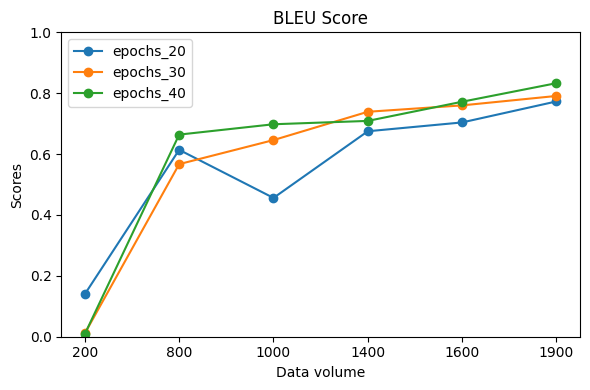

In [41]:
import matplotlib.pyplot as plt

epochs_20_bleu = df_bleu_score[df_bleu_score['epochs'] == '20']
epochs_30_bleu = df_bleu_score[df_bleu_score['epochs'] == '30']
epochs_40_bleu = df_bleu_score[df_bleu_score['epochs'] == '40']
data_index = df_bleu_score['data_volume'].unique()

plt.figure(figsize=(6, 4))
plt.plot(data_index, epochs_20_bleu['bleu_score'], label='epochs_20', marker='o')
plt.plot(data_index, epochs_30_bleu['bleu_score'], label='epochs_30', marker='o')
plt.plot(data_index, epochs_40_bleu['bleu_score'], label='epochs_40', marker='o')
plt.title('BLEU Score')
plt.xlabel('Data volume')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig('team_3_image_captioning_bleu_scores.jpg', format='jpg', dpi=300)
plt.show()

In [38]:
df_bleu_score[df_bleu_score['epochs'] == '20']

,epochs,data_volume,bleu_score
0,20,200,0.140
1,20,800,0.614
2,20,1000,0.456
3,20,1400,0.675
4,20,1600,0.704
5,20,1900,0.773
